In [1]:
!pip install torch
!pip install torchvision
# PyTorch 전체를 최신으로 다시 설치하려면 (추천)
# !pip install torch torchvision torchaudio --upgrade

   ---------------------------------------- 0.0/4.3 MB ? eta -:--:--
   ---------------------------------------- 4.3/4.3 MB 46.3 MB/s eta 0:00:00


In [2]:
# 실행마다 동일한 결과를 얻기 위해 파이토치에 랜덤 시드를 지정하고 GPU 연산을 결정적으로 만듭니다.
import torch

torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True

In [3]:
from torchvision.datasets import FashionMNIST

fm_train = FashionMNIST(root='.', train=True, download=True)
fm_test = FashionMNIST(root='.', train=False, download=True)

100%|██████████████████████████████████████████████| 26.4M/26.4M [00:04<00:00, 5.41MB/s]
100%|███████████████████████████████████████████████| 29.5k/29.5k [00:00<00:00, 115kB/s]
100%|███████████████████████████████████████████████| 4.42M/4.42M [00:11<00:00, 386kB/s]
100%|██████████████████████████████████████████████| 5.15k/5.15k [00:00<00:00, 30.2MB/s]


In [4]:
type(fm_train.data)

torch.Tensor

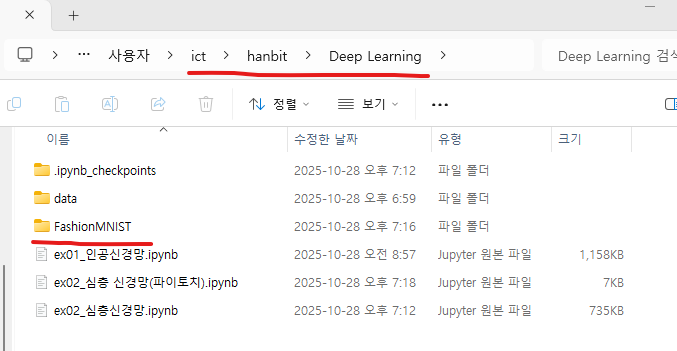

In [6]:
from IPython.display import Image, display
display(Image(filename="data/img18.png", width=800, height=600))

In [7]:
print(fm_train.data.shape, fm_test.data.shape)

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])


In [8]:
print(fm_train.targets.shape, fm_test.targets.shape)

torch.Size([60000]) torch.Size([10000])


In [9]:
train_input = fm_train.data
train_target = fm_train.targets

In [10]:
train_scaled = train_input / 255.0

In [11]:
from sklearn.model_selection import train_test_split

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

In [12]:
print(train_scaled.shape, val_scaled.shape)

torch.Size([48000, 28, 28]) torch.Size([12000, 28, 28])


In [13]:
import torch.nn as nn

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 100),
    nn.ReLU(),
    nn.Linear(100, 10)
)

In [14]:
!pip install torchinfo

In [15]:
from torchinfo import summary

summary(model, input_size=(32, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 10]                  --
├─Flatten: 1-1                           [32, 784]                 --
├─Linear: 1-2                            [32, 100]                 78,500
├─ReLU: 1-3                              [32, 100]                 --
├─Linear: 1-4                            [32, 10]                  1,010
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 2.54
Input size (MB): 0.10
Forward/backward pass size (MB): 0.03
Params size (MB): 0.32
Estimated Total Size (MB): 0.45

In [16]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=100, bias=True)
  (2): ReLU()
  (3): Linear(in_features=100, out_features=10, bias=True)
)

In [17]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [18]:
for params in model.parameters():
    print(params.shape)

torch.Size([100, 784])
torch.Size([100])
torch.Size([10, 100])
torch.Size([10])


In [19]:
epochs = 5
batches = int(len(train_scaled)/32)
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for i in range(batches):
        inputs = train_scaled[i*32:(i+1)*32].to(device)
        targets = train_target[i*32:(i+1)*32].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"에포크:{epoch + 1}, 손실:{train_loss/batches:.4f}")

에포크:1, 손실:0.5428
에포크:2, 손실:0.4004
에포크:3, 손실:0.3593
에포크:4, 손실:0.3318
에포크:5, 손실:0.3121


In [20]:
model.eval()
with torch.no_grad():
    val_scaled = val_scaled.to(device)
    val_target = val_target.to(device)
    outputs = model(val_scaled)
    predicts = torch.argmax(outputs, 1)
    corrects = (predicts == val_target).sum().item()

accuracy = corrects / len(val_target)
print(f"검증 정확도: {accuracy:.4f}")

검증 정확도: 0.8738
